# Control of a "spacecraft" platform with a reaction wheel

Import modules and configure the notebook.

In [1]:
# This module is part of the python standard library
import time

# These modules are part of other existing libraries
import numpy as np
from scipy import linalg
from scipy import signal
import sympy as sym
import matplotlib.pyplot as plt
# %matplotlib notebook
%matplotlib inline

# This is my own script (it is an interface to the pybullet simulator)
import ae353_platform

# Forces the notebook to "reload" my script to make sure we have the latest version
import importlib
importlib.reload(ae353_platform)

# Suppress the use of scientific notation when printing small numbers
np.set_printoptions(suppress=True)

In [2]:
rng = np.random.default_rng()

Create an instance of the robot simulator.

In [3]:
# # With display
# robot = ae353_platform.RobotSimulator(damping=0., pitch=0., dt=0.01, display=True)

# Without display
robot = ae353_platform.RobotSimulator(damping=0., pitch=0., dt=0.01, display=False)

Derive the linearized dynamic model.

In [4]:
# distance from platform axis to wheel axis
l = 1.

# radius of wheel
rw = 0.5

# mass of wheel
mw = 0.25

# moi of wheel
Jw = 0.5 * mw * rw**2

# mass of platform
mp = 12. * (1. - mw * l**2) / (3.**2 + 2.**2)

# moment of inertia of platform
Jp = (1. / 12.) * mp * (3.**2 + 2.**2)

# Convert floats to rationals
l_sym = sym.nsimplify(l)
mw_sym = sym.nsimplify(mw)
Jp_sym = sym.nsimplify(Jp)

# Create symbolic variables
q, v, tau = sym.symbols('q, v, tau', real=True)

# Define equations of motion
f = sym.Matrix([[v], [(1 / (Jp_sym + mw_sym * l_sym**2)) * tau]])

# Equilibrium point
q_e = 0.
v_e = 0.
tau_e = 0.

# Linearized state space model
A_num = sym.lambdify((q, v, tau), f.jacobian([q, v]))
B_num = sym.lambdify((q, v, tau), f.jacobian([tau]))
A = A_num(q_e, v_e, tau_e).astype(float)
B = B_num(q_e, v_e, tau_e).astype(float)

Derive the linearized sensor model.

In [5]:
C = np.array([[1., 0.]])

Helper function to solve LQR problems.

In [6]:
def lqr(A, B, Q, R):
    P = linalg.solve_continuous_are(A, B, Q, R)
    K = linalg.inv(R) @  B.T @ P
    return K

Design a controller.

In [7]:
# Choose gains
Qc = np.diag([100., 1.])
Rc = np.diag([1.])

# Find optimal gain matrix
K = lqr(A, B, Qc, Rc)

print(f'Gain matrix of controller:\n K = np.array({K.tolist()})\n')

# Find the closed-loop eigenvalues
print(f'Closed-loop eigenvalues of controller:\n {linalg.eigvals(A - B @ K)}')

Gain matrix of controller:
 K = np.array([[9.999999999999995, 4.582575694955839]])

Closed-loop eigenvalues of controller:
 [-2.29128785+2.17944947j -2.29128785-2.17944947j]


Design an observer.

In [8]:
# Choose gains
Qo = np.diag([10.])
Ro = np.diag([1., 1.])

# Find optimal gain matrix
L = lqr(A.T, C.T, linalg.inv(Ro), linalg.inv(Qo)).T

print(f'Gain matrix of observer:\n L = np.array({L.tolist()})\n')

# Find the closed-loop eigenvalues
print(f'Closed-loop eigenvalues of observer:\n {linalg.eigvals(A - L @ C)}')

Gain matrix of observer:
 L = np.array([[4.040365740912174], [3.162277660168378]])

Closed-loop eigenvalues of observer:
 [-2.97875534+0.j -1.06161041+0.j]


Implement controller and observer.

In [9]:
class RobotController:
    def __init__(self, dt, q_e, A, B, C, K, L):
        self.dt = dt
        self.q_e = q_e
        self.v_e = 0.
        self.tau_e = 0.
        self.A = A
        self.B = B
        self.C = C
        self.K = K
        self.L = L
        
        # Run the reset function to initialize the state estimate
        self.reset() 
        
    
    def reset(self, xhat=None):
        # Initialize the state estimate
        if xhat is None:
            self.xhat = np.array([[0.], [0.]])
        else:
            self.xhat = xhat
        
    
    def run(self, q, q_des):
        # Define the desired state
        x_des = np.array([[q_des - self.q_e], [0.]])
        
        # Apply controller
        u = -self.K @ (self.xhat - x_des)
        
        # Convert input to actuator commands
        tau_on_platform = u[0, 0] + self.tau_e
        
        # Define output
        y = np.array([[q - self.q_e]])
        
        # Apply observer to update state estimate
        self.xhat += self.dt * (self.A @ self.xhat + self.B @ u - self.L @ (self.C @ self.xhat - y))
        
        # Don't forget to convert "torque on platform" to "torque on wheel"
        tau = -tau_on_platform
        
        return tau

Create an instance of the RobotController class (i.e., of our implementation) for us to use in simulation.

In [10]:
controller = RobotController(dt=robot.dt,
                             q_e=q_e,
                             A=A,
                             B=B,
                             C=C,
                             K=K,
                             L=L)

Simulate.

(0.0, 9.99)

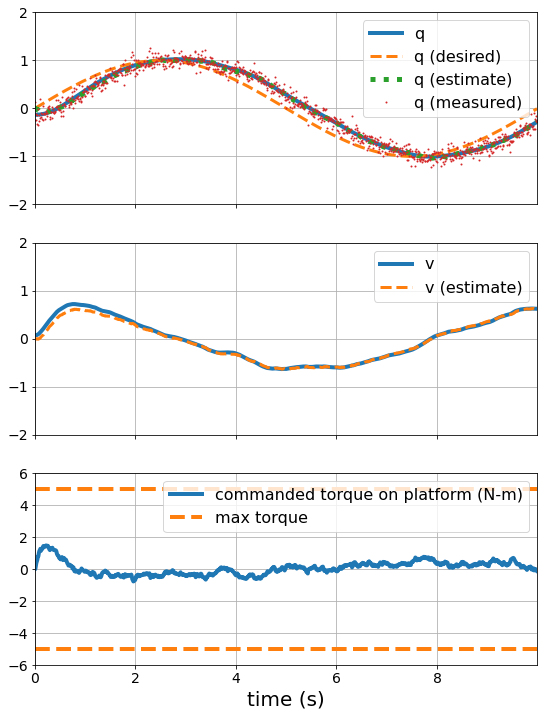

In [12]:
##############################################
# Restore the simulation to its initial state
#

# Choose initial conditions
q_platform = 0.1 * rng.standard_normal()
q_wheel = 0.1 * rng.standard_normal()
v_platform = 0.1 * rng.standard_normal()
v_wheel = 0.1 * rng.standard_normal()

# Apply initial conditions
robot.set_state(np.array([q_platform, q_wheel]), np.array([v_platform, v_wheel]))

#
##############################################

##############################################
# Restore the observer to its initial state
#

controller.reset(xhat=np.array([[0.], [0.]]))

#
##############################################


# Choose how long we want to run the simulation, and
# compute the corresponding number of time steps
run_time = 10.
num_steps = int(run_time/robot.dt)

# Create a dictionary in which to store results
data = {
    't': np.empty(num_steps, dtype=float),
    'q': np.empty(num_steps, dtype=float),
    'v': np.empty(num_steps, dtype=float),
    'q_wheel': np.empty(num_steps, dtype=float),
    'v_wheel': np.empty(num_steps, dtype=float),
    'q_meas': np.empty(num_steps, dtype=float),
    'q_des': np.empty(num_steps, dtype=float),
    'xhat': np.empty((2, num_steps), dtype=float),
    'tau': np.empty(num_steps, dtype=float),
}

# Run the simulation loop
start_time = time.time()
for step in range(num_steps):
    # Get the current time
    t = robot.dt * step
    
    # Get desired angle
    q_des = 0.
#     q_des = 1. if t >= 5. else 0.
#     if t <= 2.5:
#         q_des = 0.
#     elif t <= 7.5:
#         q_des = ((t - 2.5) / 5.) * 1.
#     else:
#         q_des = 1.
    q_des = np.sin((2. * np.pi / 10.) * t)
    
    # Get the sensor measurements
    q_true, v_true, q_wheel_true, v_wheel_true = robot.get_sensor_measurements()
    
    # Add noise to sensor measurements
    q_meas = q_true + 0.1 * np.random.randn()
    
    # Log the state estimate
    data['xhat'][:, step] = controller.xhat.flatten()
    
    # Choose the actuator command (by running the controller)
    tau = controller.run(q_meas, q_des)
    
    # Log the data from this time step
    data['t'][step] = t
    data['q'][step] = q_true
    data['v'][step] = v_true
    data['q_wheel'][step] = q_wheel_true
    data['v_wheel'][step] = v_wheel_true
    data['q_meas'][step] = q_meas
    data['q_des'][step] = q_des
    data['tau'][step] = tau
    
    # Send the actuator commands to robot and go forward one time
    # step (this is where the actual simulation happens)
    robot.set_actuator_commands(tau)
    robot.step(t=(start_time + (robot.dt * (step + 1))))

# Extract estimates of q and v
q_est = data['xhat'][0, :] + controller.q_e
v_est = data['xhat'][1, :] + controller.v_e

# Compare estimates to real values
fig, (ax_q, ax_v, ax_tau) = plt.subplots(3, 1, figsize=(9, 12), sharex=True)

ax_q.plot(data['t'], data['q'], label='q', linewidth=4)
ax_q.plot(data['t'], data['q_des'], '--', label='q (desired)', linewidth=3)
ax_q.plot(data['t'], q_est, ':', label='q (estimate)', linewidth=5)
ax_q.plot(data['t'], data['q_meas'], '.', label='q (measured)', markersize=2)
ax_q.grid()
ax_q.legend(fontsize=16)
ax_q.tick_params(labelsize=14)
ax_q.set_ylim(-2., 2.)

ax_v.plot(data['t'], data['v'], label='v', linewidth=4)
ax_v.plot(data['t'], v_est, '--', label='v (estimate)', linewidth=3)
ax_v.grid()
ax_v.legend(fontsize=16)
ax_v.tick_params(labelsize=14)
ax_v.set_ylim(-2., 2.)

# take the negative of data['tau'] to plot torque on platform, not wheel
ax_tau.plot(data['t'], -data['tau'], label='commanded torque on platform (N-m)', linewidth=4)
ax_tau.plot(data['t'], np.ones_like(data['t']) * robot.tau_max, '--', label='max torque', linewidth=4, color='C1')
ax_tau.plot(data['t'], -np.ones_like(data['t']) * robot.tau_max, '--', linewidth=4, color='C1')
ax_tau.grid()
ax_tau.legend(fontsize=16, loc='upper right')
ax_tau.tick_params(labelsize=14)
ax_tau.set_ylim(-1.2 * robot.tau_max, 1.2 * robot.tau_max)

ax_tau.set_xlabel('time (s)', fontsize=20)
ax_tau.set_xlim([data['t'][0], data['t'][-1]])

Compare results in simulation to what is predicted by the state-space model.

In [ ]:
t = data['t']
nt = len(t)
t0 = t[0]
t1 = t[-1]
xerr0 = np.array([[-1.], [0.]])
xerr = np.empty((2, nt), dtype=float)

for i in range(len(t)):
    xerri = linalg.expm((A - L @ C) * (t[i] - t0)) @ xerr0
    xerr[:, i] = xerri.flatten()

fig, (ax_xerr1, ax_xerr2) = plt.subplots(2, 1, figsize=(9, 6), sharex=True, tight_layout=True)

ax_xerr1.plot(t, xerr[0, :], label='error in $x_1$ (linear)', linewidth=3)
ax_xerr1.plot(t, q_est - data['q'], '--', label='error in $x_1$ (nonlinear)', linewidth=4)
ax_xerr1.grid()
ax_xerr1.legend()
ax_xerr1.legend(fontsize=16)
ax_xerr1.tick_params(labelsize=14)
ax_xerr1.set_ylim(-1., 1.)

ax_xerr2.plot(t, xerr[1, :], label='error in $x_2$ (linear)', linewidth=3)
ax_xerr2.plot(t, v_est - data['v'], '--', label='error in $x_2$ (nonlinear)', linewidth=4)
ax_xerr2.grid()
ax_xerr2.legend()
ax_xerr2.legend(fontsize=16)
ax_xerr2.tick_params(labelsize=14)
ax_xerr2.set_ylim(-1., 1.)

ax_xerr2.set_xlim(t0, t1)
ax_xerr2.set_xlabel('time (s)', fontsize=20)

fig.tight_layout()

Plot **only** the results predicted by the state-space model.

In [ ]:
L = np.array([[100.], [100.]])

In [ ]:
t0 = 0.
t1 = 10.
nt = 1 + int((t1 - t0) / robot.dt)
xerr0 = np.array([[-1.], [0.]])
t = np.linspace(t0, t1, nt)
xerr = np.empty((2, nt), dtype=float)

for i in range(len(t)):
    xerri = linalg.expm((A - L @ C) * (t[i] - t0)) @ xerr0
    xerr[:, i] = xerri.flatten()

fig, (ax_xerr1, ax_xerr2) = plt.subplots(2, 1, figsize=(9, 6), sharex=True, tight_layout=True)

ax_xerr1.plot(t, xerr[0, :], label='error in $x_1$ (linear)', linewidth=3)
ax_xerr1.grid()
ax_xerr1.legend()
ax_xerr1.legend(fontsize=16)
ax_xerr1.tick_params(labelsize=14)
ax_xerr1.set_ylim(-1., 1.)

ax_xerr2.plot(t, xerr[1, :], label='error in $x_2$ (linear)', linewidth=3)
ax_xerr2.grid()
ax_xerr2.legend()
ax_xerr2.legend(fontsize=16)
ax_xerr2.tick_params(labelsize=14)
ax_xerr2.set_ylim(-1., 1.)

ax_xerr2.set_xlim(t0, t1)
ax_xerr2.set_xlabel('time (s)', fontsize=20)

fig.tight_layout()

In [ ]:
settling_times = []
num_trials = 100
for trial in range(num_trials):
    ##############################################
    # Restore the simulation to its initial state
    #

    # Choose initial conditions
    q_platform = controller.q_e + 1.
    q_wheel = 0.
    v_platform = 0.
    v_wheel = 0.

    # Apply initial conditions
    robot.set_state(np.array([q_platform, q_wheel]), np.array([v_platform, v_wheel]))

    #
    ##############################################

    ##############################################
    # Restore the observer to its initial state
    #

    controller.reset(xhat=np.array([[0.], [0.]]))

    #
    ##############################################


    # Choose how long we want to run the simulation, and
    # compute the corresponding number of time steps
    run_time = 10.
    num_steps = int(run_time/robot.dt)

    # Create a dictionary in which to store results
    data = {
        't': np.empty(num_steps, dtype=float),
        'q': np.empty(num_steps, dtype=float),
        'v': np.empty(num_steps, dtype=float),
        'q_wheel': np.empty(num_steps, dtype=float),
        'v_wheel': np.empty(num_steps, dtype=float),
        'q_meas': np.empty(num_steps, dtype=float),
        'xhat': np.empty((2, num_steps), dtype=float),
        'tau': np.empty(num_steps, dtype=float),
    }

    # Run the simulation loop
    start_time = time.time()
    for step in range(num_steps):
        # Get the current time
        t = robot.dt * step

        # Get the sensor measurements
        q_true, v_true, q_wheel_true, v_wheel_true = robot.get_sensor_measurements()

        # Add noise to sensor measurements
        q_meas = q_true + 0.5 * np.random.randn()

        # Log the state estimate
        data['xhat'][:, step] = controller.xhat.flatten()

        # Choose the actuator command (by running the controller)
        tau = controller.run(q_meas)

        # Log the data from this time step
        data['t'][step] = t
        data['q'][step] = q_true
        data['v'][step] = v_true
        data['q_wheel'][step] = q_wheel_true
        data['v_wheel'][step] = v_wheel_true
        data['q_meas'][step] = q_meas
        data['tau'][step] = tau

        # Send the actuator commands to robot and go forward one time
        # step (this is where the actual simulation happens)
        robot.set_actuator_commands(tau)
        robot.step(t=(start_time + (robot.dt * (step + 1))))

    # Extract estimates of q and v
    q_est = data['xhat'][0, :] + controller.q_e
    v_est = data['xhat'][1, :] + controller.v_e

    # # Compare estimates to real values
    # fig, (ax_q, ax_v, ax_tau) = plt.subplots(3, 1, figsize=(9, 12), sharex=True)

    # ax_q.plot(data['t'], data['q'], label='q', linewidth=4)
    # ax_q.plot(data['t'], q_est, '--', label='q (estimate)', linewidth=3)
    # ax_q.plot(data['t'], data['q_meas'], '.', label='q (measured)', markersize=2)
    # ax_q.grid()
    # ax_q.legend(fontsize=16)
    # ax_q.tick_params(labelsize=14)
    # ax_q.set_ylim(-2., 2.)

    # ax_v.plot(data['t'], data['v'], label='v', linewidth=4)
    # ax_v.plot(data['t'], v_est, '--', label='v (estimate)', linewidth=3)
    # ax_v.grid()
    # ax_v.legend(fontsize=16)
    # ax_v.tick_params(labelsize=14)
    # ax_v.set_ylim(-2., 2.)

    # # take the negative of data['tau'] to plot torque on platform, not wheel
    # ax_tau.plot(data['t'], -data['tau'], label='commanded torque on platform (N-m)', linewidth=4)
    # ax_tau.plot(data['t'], np.ones_like(data['t']) * robot.tau_max, '--', label='max torque', linewidth=4, color='C1')
    # ax_tau.plot(data['t'], -np.ones_like(data['t']) * robot.tau_max, '--', linewidth=4, color='C1')
    # ax_tau.grid()
    # ax_tau.legend(fontsize=16, loc='upper right')
    # ax_tau.tick_params(labelsize=14)
    # ax_tau.set_ylim(-1.2 * robot.tau_max, 1.2 * robot.tau_max)

    # ax_tau.set_xlabel('time (s)', fontsize=20)
    # ax_tau.set_xlim([data['t'][0], data['t'][-1]])


    for i in range(num_steps):
        if (np.abs(data['q'][i:]) < 0.1).all():
            settling_time = data['t'][i]
            break

    settling_times.append(settling_time)
    
    if (trial + 1) % 10 == 0:
        print(f' {trial + 1} / {num_trials}')
#     print(settling_time)


In [ ]:
settling_times

In [ ]:
plt.hist(settling_times)

In [ ]:
np.mean(settling_times)

In [ ]:
np.max(settling_times)

In [ ]:
np.min(settling_times)

In [ ]:
np.std(settling_times)

In [ ]:
np.median(settling_times)